In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, precision_recall_curve, accuracy_score, precision_score, recall_score, roc_auc_score
from typing import Callable
import numpy.typing as npt
from enum import Enum

import os
import optuna
import glob

folder_path = os.getcwd() + "/data/csvs"
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))


class Metrics(Enum):
    all = 0
    auprc = 1
    auc_roc = 2
    precision = 3
    recall = 4
    accuracy = 5


def score_predictions(y_truth, y_predictions):
    score = {}

    precision, recall, _ = precision_recall_curve(y_truth, y_predictions)
    score["auprc"] = auc(recall, precision)
    score["auc_roc"] = roc_auc_score(y_truth, y_predictions)
    score["precision"] = precision_score(y_truth, y_predictions)
    score["recall"] = recall_score(y_truth, y_predictions)
    score["accuracy"] = accuracy_score(y_truth, y_predictions)

    return score

def eval_model(model: BaseEstimator, X_test: npt.ArrayLike, y_test: npt.ArrayLike):
    predictions = model.predict(X_test)

    predictions[predictions == -1] = 0

    return score_predictions(y_test, predictions)


def unsupervised_trainer_factory(model: BaseEstimator, X_train: npt.ArrayLike, y_train: npt.ArrayLike, X_test: npt.ArrayLike, y_test: npt.ArrayLike, metric: Metrics | None = None) -> Callable:
    def trainer(**kwargs) -> tuple[BaseEstimator, str]:
        mdl = model(**kwargs).fit(X_train)
        score = eval_model(mdl, X_test, y_test)

        if metric != "all" or metric:
            return score[metric]

        return score

    return trainer

TARGET_METRIC = 'auprc'

print("Setup Complete")

Setup Complete


/home/evanvance/miniconda3/envs/ids-ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfs = []

for file in csv_files:
    filename = file.split("/")[-1]
    df = pd.read_csv(file)
    df["Source File"] = filename
    dfs.append(df)

captures = pd.concat(dfs)
captures.rename(columns={name:name.strip() for name in captures.columns}, inplace=True)

In [ ]:
captures.shape

(2830743, 80)

In [ ]:

captures["Label"].unique()


array(['BENIGN', 'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'DDoS', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'FTP-Patator', 'SSH-Patator', 'Bot', 'Infiltration', 'PortScan'],
      dtype=object)

In [3]:
captures["Label"] = captures["Label"] == 'BENIGN'

In [4]:
le = LabelEncoder()

captures["Label"] = le.fit_transform(captures["Label"])

This Next Block is important to note. The Isolation forest cannot deal with infinity so it must be delt with.

In [5]:
captures = captures.replace([np.inf, -np.inf], np.nan)
captures.dropna(inplace=True)

In [ ]:
captures.shape

(2827876, 80)

In [6]:
features = captures.columns.drop(["Label", "Source File"])

X = captures[features]
y = captures["Label"]

X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, train_size=.8, test_size=.2, random_state=0)

/home/evanvance/miniconda3/envs/ids-ai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


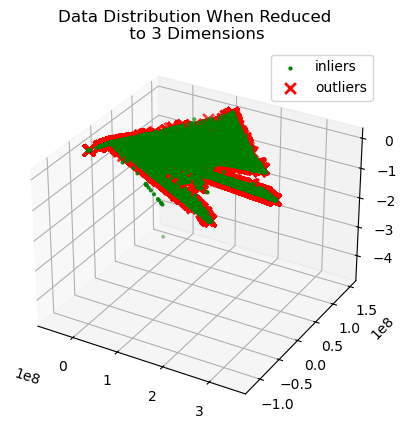

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[(y == True).index,0],X_reduce[(y == True).index,1], X_reduce[(y == True).index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
ax.set_title("Data Distribution When Reduced\n to 3 Dimensions")
plt.show()

In [ ]:
isoforest_trainer = unsupervised_trainer_factory(
        IsolationForest, 
        X_train, y_train, X_test, y_test, 
        metric=TARGET_METRIC
    )

def objective(trial, params):
    params["n_estimators"] = trial.suggest_int("n_estimators", 50, 500)
    params["bootstrap"] = trial.suggest_categorical("bootstrap", [True, False])
    params["max_samples"] = trial.suggest_float("max_samples", .3, 1.0)

    return isoforest_trainer(**params)

iso_forest_params = {
    "random_state":0,
    "n_jobs":-1,
    "n_estimators":100,
    "max_samples": 1.0
}

In [ ]:
iso_forest_default_score = isoforest_trainer(random_state=0, n_jobs=-1)

iso_forest_default_score

0.9037196096276872

In [ ]:
iso_forest_study = optuna.create_study(directions=["maximize"], study_name="Isolation Forest Parameter Tuning")
iso_forest_study.optimize(lambda trial: objective(trial, iso_forest_params), n_trials=500)

print(iso_forest_study.best_params)

[I 2024-11-25 21:01:30,346] A new study created in memory with name: Isolation Forest Parameter Tuning
[I 2024-11-25 21:03:03,502] Trial 0 finished with value: 0.9012295339898296 and parameters: {'n_estimators': 365, 'bootstrap': False, 'max_samples': 0.38401100627586854}. Best is trial 0 with value: 0.9012295339898296.
[I 2024-11-25 21:04:22,630] Trial 1 finished with value: 0.9011935612889993 and parameters: {'n_estimators': 324, 'bootstrap': True, 'max_samples': 0.6370582978647894}. Best is trial 0 with value: 0.9012295339898296.
[I 2024-11-25 21:05:13,173] Trial 2 finished with value: 0.9012746572129453 and parameters: {'n_estimators': 158, 'bootstrap': False, 'max_samples': 0.6523639654194198}. Best is trial 2 with value: 0.9012746572129453.
[I 2024-11-25 21:06:41,304] Trial 3 finished with value: 0.9012068349679676 and parameters: {'n_estimators': 280, 'bootstrap': True, 'max_samples': 0.9864232356519134}. Best is trial 2 with value: 0.9012746572129453.
[I 2024-11-25 21:07:00,872

{'n_estimators': 110, 'bootstrap': False, 'max_samples': 0.917152528455259}


No real value was gained by parameter tuning the isolation forest.

In [ ]:
ocsvm_trainer = unsupervised_trainer_factory(
        OneClassSVM, 
        X_train, y_train, X_test, y_test, 
        metric=TARGET_METRIC
    )

ocsvm_params = {
    "gamma":"scale",
    "nu":.5
}

def objective(trial, params):
    params["gamma"] = trial.suggest_float("gamma", .3, 1.0)
    params["nu"] = trial.suggest_float("nu", .1, .9)

    return ocsvm_trainer(**params)



In [ ]:
ocsvm_default_score = ocsvm_trainer()

ocsvm_default_score

: 

: 

The default ocsvm took over a day to train, so it was determined to not be worth the effort to try to find good parameters for it since we likely wont use it. We could reduce the dementions of the data, but the Isolation Forest is performing pretty well all things considered so it doesnt seem worth the trouble.

In [ ]:
# ocsvm_study = optuna.create_study(directions=["maximize"], study_name="One Class SVM Parameter Tuning")
# ocsvm_study.optimize(lambda trial: objective(trial, ocsvm_params), n_trials=100)

# print(ocsvm_study.best_params)

[I 2024-11-26 08:42:07,936] A new study created in memory with name: One Class SVM Parameter Tuning


Due to how LOF works, we want to pass it the whole dataset. I am not sure how this would change our application architecture so I will think about that.

In [ ]:
def lof_trainer(**kwargs):
    lof = LocalOutlierFactor(**kwargs, n_jobs=-1)

    predictions = lof.fit_predict(X)
    predictions[predictions == -1] = 0

    return score_predictions(y, predictions)[TARGET_METRIC]

lof_params = {
    "n_neighbors":20,
    "leaf_size":30,
}

def objective(trial, params):
    params["n_neighbors"] = trial.suggest_int("n_neighbors", 10, 40)
    params["leaf_size"] = trial.suggest_int("leaf_size", 15, 50)

    return lof_trainer(**params)


In [ ]:
lof_default_score = lof_trainer()

lof_default_score

0.8925611696904747

In [ ]:
lof_study = optuna.create_study(directions=["maximize"], study_name="Local Outlier Factor Parameter Tuning")
lof_study.optimize(lambda trial: objective(trial, lof_params), n_trials=50)

print(lof_study.best_params)

[I 2024-11-29 12:41:39,282] A new study created in memory with name: Local Outlier Factor Parameter Tuning
[I 2024-11-29 15:27:06,123] Trial 0 finished with value: 0.8927222414062816 and parameters: {'n_neighbors': 24, 'leaf_size': 48}. Best is trial 0 with value: 0.8927222414062816.
[I 2024-11-29 18:12:56,963] Trial 1 finished with value: 0.8927370616846093 and parameters: {'n_neighbors': 38, 'leaf_size': 16}. Best is trial 1 with value: 0.8927370616846093.
[I 2024-11-29 20:58:28,703] Trial 2 finished with value: 0.8925611696904747 and parameters: {'n_neighbors': 20, 'leaf_size': 32}. Best is trial 1 with value: 0.8927370616846093.
[I 2024-11-29 23:35:34,503] Trial 3 finished with value: 0.8925611696904747 and parameters: {'n_neighbors': 20, 'leaf_size': 42}. Best is trial 1 with value: 0.8927370616846093.
[I 2024-11-30 02:12:41,895] Trial 4 finished with value: 0.8928363657937387 and parameters: {'n_neighbors': 30, 'leaf_size': 26}. Best is trial 4 with value: 0.8928363657937387.
[I 

We kinda ran out of time to finish this lof study. Started this portion too late. The initial results align with the early assumptions that were made.

In [ ]:
km_trainer = unsupervised_trainer_factory(
        KMeans, 
        X_train, y_train, X_test, y_test, 
        metric=TARGET_METRIC
    )

km_params = {
    "random_state":0,
    "n_clusters":2,
    "tol":1e-4,
    "max_iter":300
}

def objective(trial, params):
    params["tol"] = trial.suggest_float("tol", 1e-6, 1e-2)
    params["max_iter"] = trial.suggest_int("max_iter", 150, 450)

    return km_trainer(**params)

In [ ]:
km_default_score = km_trainer(random_state=0, n_clusters=2)

km_default_score

0.6789967169683734

In [ ]:
km_study = optuna.create_study(directions=["maximize"], study_name="KMeans Parameter Tuning")
km_study.optimize(lambda trial: objective(trial, km_params), n_trials=500)

print(km_study.best_params)

[I 2024-11-27 11:54:59,407] A new study created in memory with name: KMeans Parameter Tuning
[I 2024-11-27 11:55:02,987] Trial 0 finished with value: 0.6789967169683734 and parameters: {'tol': 0.0001064020194153802, 'max_iter': 268}. Best is trial 0 with value: 0.6789967169683734.
[I 2024-11-27 11:55:06,593] Trial 1 finished with value: 0.6789967169683734 and parameters: {'tol': 0.0048789452142420356, 'max_iter': 306}. Best is trial 0 with value: 0.6789967169683734.
[I 2024-11-27 11:55:10,145] Trial 2 finished with value: 0.6789967169683734 and parameters: {'tol': 0.002103170040431962, 'max_iter': 381}. Best is trial 0 with value: 0.6789967169683734.
[I 2024-11-27 11:55:13,686] Trial 3 finished with value: 0.6789900009396592 and parameters: {'tol': 0.008605392820339177, 'max_iter': 419}. Best is trial 0 with value: 0.6789967169683734.
[I 2024-11-27 11:55:17,169] Trial 4 finished with value: 0.6789967169683734 and parameters: {'tol': 0.0005118084241543433, 'max_iter': 358}. Best is tria

{'tol': 0.0001064020194153802, 'max_iter': 268}


Nothing performed as well as the Isolation forest. That is the one we are choosing for our application.